In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
!kaggle datasets download -d techsash/waste-classification-data

 98% 420M/427M [00:14<00:00, 21.5MB/s]
100% 427M/427M [00:14<00:00, 30.3MB/s]


In [7]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5515.jpg  
  i

In [8]:
base_dir = 'DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
train_organic_dir = os.path.join(train_dir, 'O')  # directory with our training organic images
train_recylable_dir = os.path.join(train_dir, 'R')  # directory with our training recylable images

In [115]:
test_dir = os.path.join(base_dir, 'TEST')

In [9]:
#Understanding our dataset

num_organic_tr = len(os.listdir(train_organic_dir))
num_recylable_tr = len(os.listdir(train_recylable_dir))
total_train = num_organic_tr + num_recylable_tr

In [10]:
print('total training organic images:', num_organic_tr)
print('total training recylable images:', num_recylable_tr)
print("--")
print("Total training images:", total_train)

total training organic images: 12565
total training recylable images: 9999
--
Total training images: 22564


In [11]:
#Setting model params
BATCH_SIZE = 100
IMG_SHAPE  = 299 # Our training data consists of images with width of 299 pixels and height of 299 pixels

In [12]:
#Plotting function
#Creates a 1x5 matrix of images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. 

# Flip Image Horizontally

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 22564 images belonging to 2 classes.


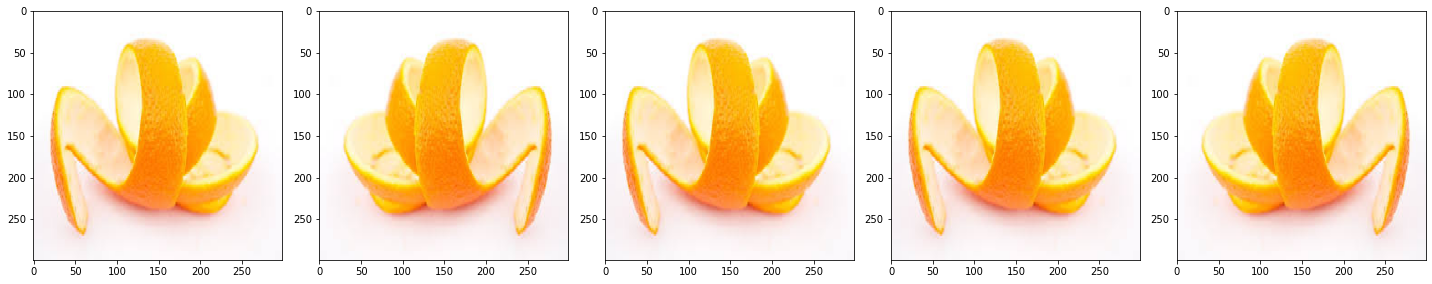

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Rotate Images

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 22564 images belonging to 2 classes.


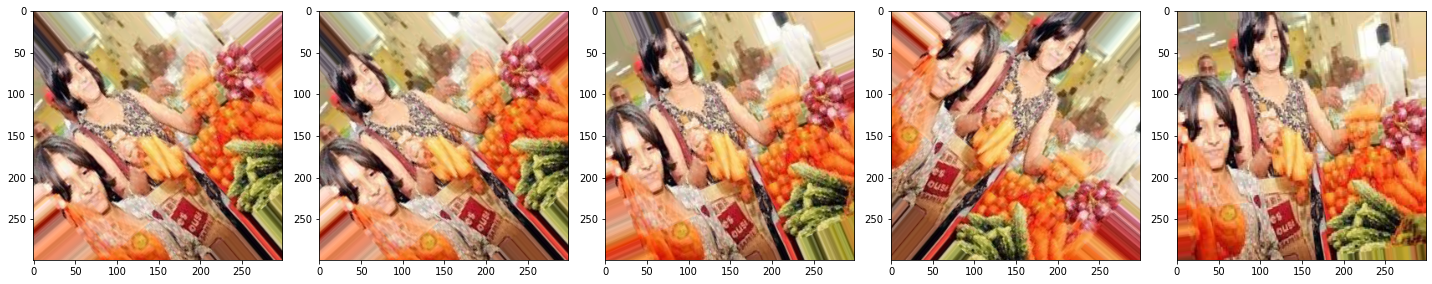

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#Applying Zoom

In [17]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 22564 images belonging to 2 classes.


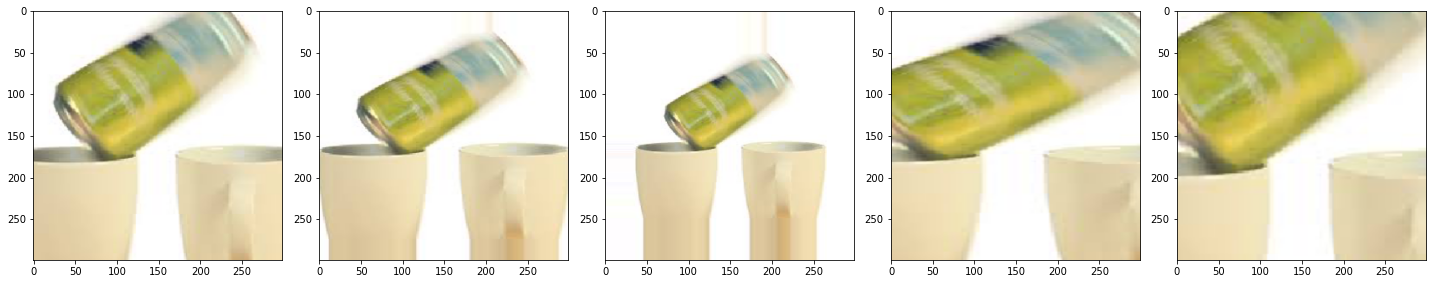

In [18]:
augmented_images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(augmented_images)

#Putting it all together

In [19]:
#Generating a 70:30 split for training and validation, coupled with image augmentation applied to the dataset
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.3,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     subset = 'training',
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')
validation_data_gen = image_gen_train.flow_from_directory(directory=train_dir,
                                                          subset='validation',
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                          class_mode='binary')

Found 15796 images belonging to 2 classes.
Found 6768 images belonging to 2 classes.


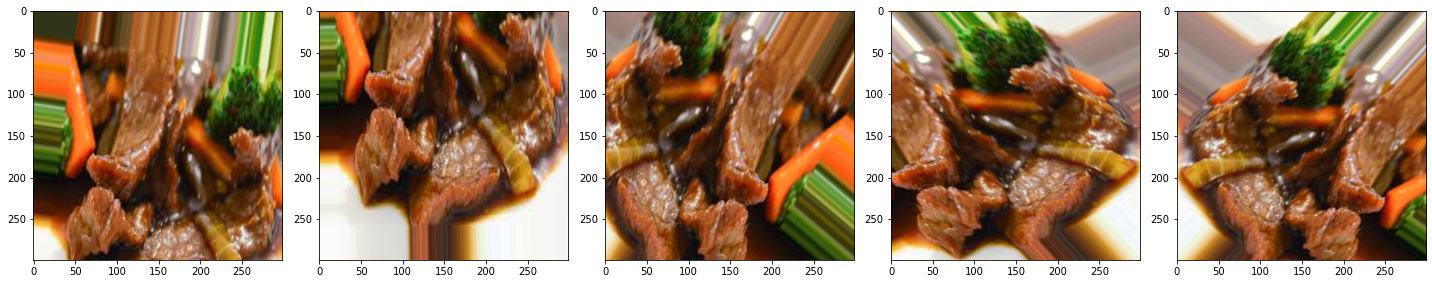

In [20]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#Transfer Learning with InceptionV3

In [21]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(train_data_gen.num_classes)
])

model_inception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 100 #Customisable

history = model_inception.fit_generator(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=validation_data_gen)

Epoch 1/100
158/158 [==============================] - 530s 3s/step - loss: 0.1329 - accuracy: 0.9482 - val_loss: 0.2168 - val_accuracy: 0.9180
Epoch 2/100
158/158 [==============================] - 527s 3s/step - loss: 0.1338 - accuracy: 0.9485 - val_loss: 0.2145 - val_accuracy: 0.9186
Epoch 3/100
158/158 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9481

#Visualising Training Accuracy and Validation Loss

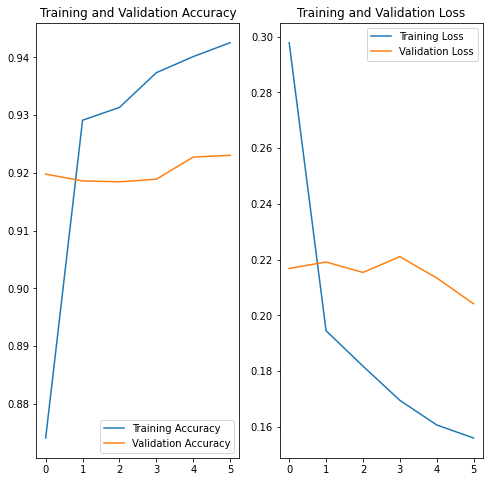

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Using our model to make predictions on the Test Dataset

In [116]:
test_image_gen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=test_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2513 images belonging to 2 classes.


In [117]:
image_batch, label_batch = next(iter(test_data_gen))

predicted_batch = model_inception.predict(image_batch)

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = []
for i in range(len(predicted_ids)):
  if (predicted_ids[i]==0):
    predicted_class_names.insert(i,"Organic")
  elif (predicted_ids[i]==1):
    predicted_class_names.insert(i,"Recylable")
print(predicted_class_names)
print(predicted_ids)

['Organic', 'Organic', 'Recylable', 'Organic', 'Organic', 'Recylable', 'Recylable', 'Recylable', 'Recylable', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Organic', 'Recylable', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Recylable', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Organic', 'Organic', 'Organic', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Recylable', 'Organic', 'Organic', 'Recylable', 'Organic', 'Organic', 'Organic', 'Organic', 'Recylable', 'Recylable', 'Recylable', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Recylable', 'Recylable', 'Recylable', 'Organic', 'Organic', 'Recylable', 'Organic', 'Recylable', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic', 'Organic

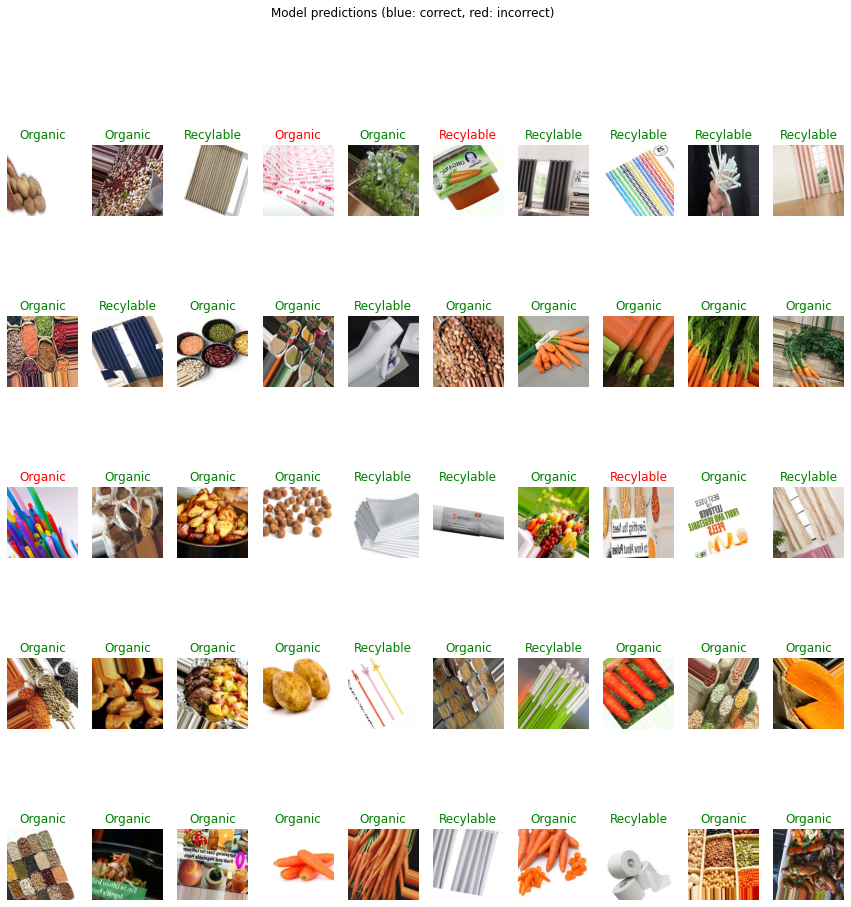

In [127]:
plt.figure(figsize=(15,15))
for n in range(50):
  plt.subplot(5,10,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "green" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n], color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")